In [2]:
from PyPurityTools import PyPurityTools as ppt
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt

import scipy.fftpack

#Set default figure size
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [70]:
#Get some data
dirName="/Users/rjn/dune/data/preampCalibration_10052022/"
#fileBase="preampA_473nF_captest_oneleg_take2"
#fileBase="preampA_473nF_captest_inbox_oneleg"
#fileBase="preampA_473nF_captest_15MOhm_resistor"
#fileBase="preampA_473nF_captest_15MOhm_resistor_lidscrewedon"
#fileBase="preampA_473nF_captest_15MOhm_resistor_lidscrewedon_take2"
#fileBase="preampA_473nF_captest_oneleg_boxopen"
#fileBase="preampA_473nF_captest_oneleg_boxclosed"
#fileBase="preampA_473nF_captest_oneleg_boxclosed_screwson_all"
fileBaseList=['preampA_473nF_captest_1GOhm_lidscrewedon','preampA_473nF_captest_1GOhm_lidscrewedon_take2','preampA_473nF_captest_1GOhm_lidscrewedon_take3','preampA_473nF_captest_10MOhm_lidscrewedon','preampA_473nF_captest_10MOhm_lidscrewedon_take2']


#The line below use Python list comprehension to make a new list e.g. [x for x in listOfX]
inputThing = [ppt.getScopeWaveforms(dirName+fileBase+".ch4.traces",False) for fileBase in fileBaseList]
outputThing = [ppt.getScopeWaveforms(dirName+fileBase+".ch3.traces",False) for fileBase in fileBaseList]

#The line below use Python list comprehension to make a new list e.g. [x for x in listOfX]
inputAvg = [np.mean(thing[0],axis=0) for thing in inputThing]
outputAvg = [np.mean(thing[0],axis=0) for thing in outputThing]

#Let's just assume all the times are the same
timeList=inputThing[0][1]

Text(0, 0.5, 'Voltage (Volts)')

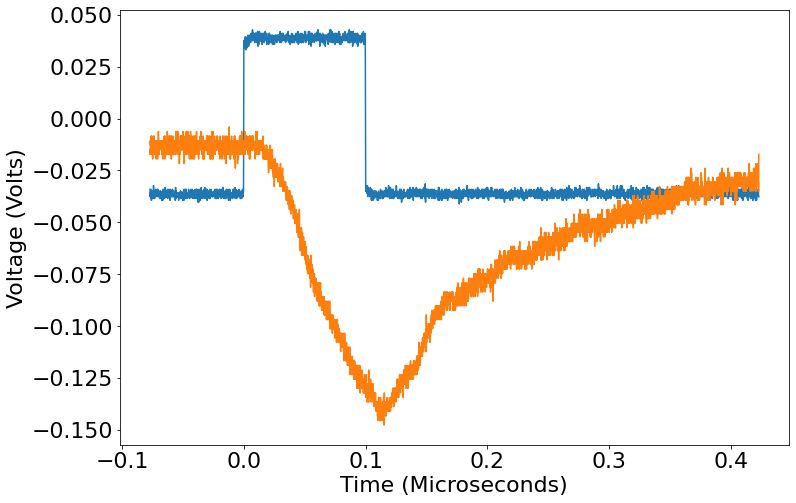

In [71]:
#Plot the first waveforms
fig, ax = plt.subplots()
ax.plot(timeList,inputThing[0][0][0],label="Input Pulse")
ax.plot(timeList,outputThing[0][0][0],label="Preamp Output")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")

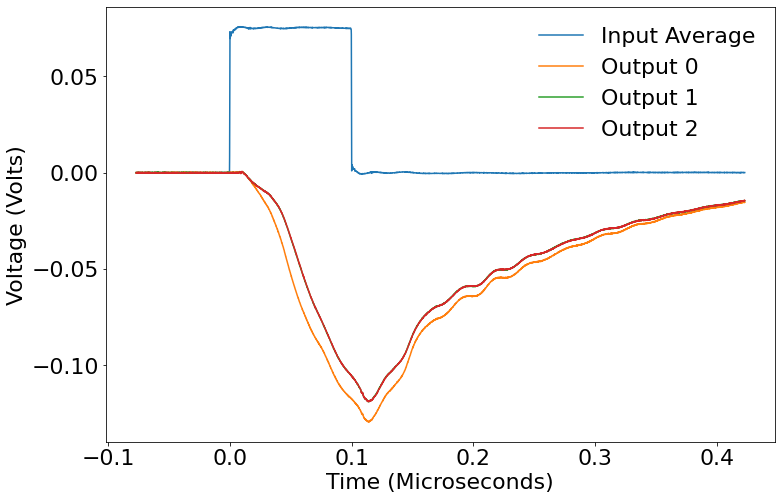

In [57]:
dt=timeList[1]-timeList[0]
fs=1./dt

#Do some zero subtraction
for i in range(np.shape(inputAvg)[0]):
    inputAvg[i]-=np.mean(inputAvg[i][0:100])
    outputAvg[i]-=np.mean(outputAvg[i][0:100])

fig, ax = plt.subplots()
ax.plot(timeList,inputAvg[0],label="Input Average")
for idx,output in enumerate(outputAvg):
    ax.plot(timeList,output,label="Output "+str(idx))
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Voltage (Volts)")
ax.legend()


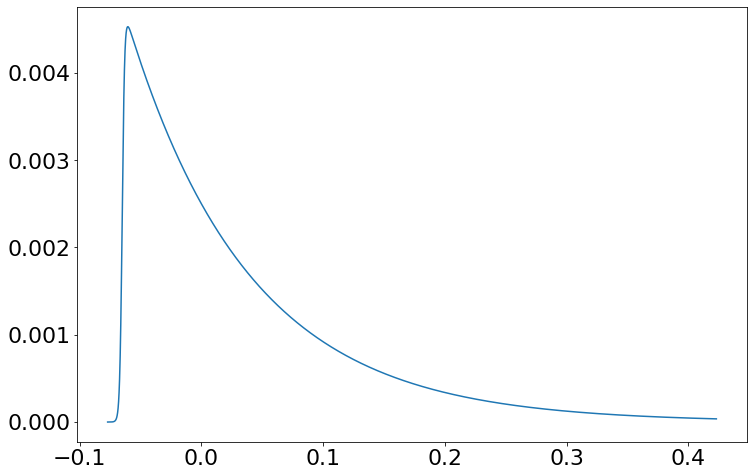

In [58]:
#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls with a given time constant
def response2(x,offset,tau,tauRise,norm):
    return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  

#Define a function which will operate on an array of x values all at once
#This function is zero until some offset and then exponential falls with a given time constant
def response(x,offset,tau,norm):
    conds = [x<0,(x>=0) & (x < offset), x>=offset]   #The two regions of x
    funcs = [lambda x: 0, lambda x:0, lambda x: norm*np.exp(-x/tau)]  #the lambda keyword is allowing us to define a quick function
    return np.piecewise(x, conds, funcs)  #Now do the piecewise calculation and return it


offset=timeList[120]
tau=0.1
tauRise=0.001
norm=0.0025
fig, ax = plt.subplots()
ax.plot(timeList[0:10000],response2(timeList[0:10000],offset,tau,tauRise,norm),label="Response Function")



/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78440/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78440/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78440/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function


[-6.26790981e-02  1.36753970e-01  2.14279026e-06 -1.49434570e-03]
[-0.05853656  0.13719638  0.00029677 -0.00138811]
[-6.15168331e-02  1.43545226e-01  7.52402166e-07 -1.34492769e-03]


/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78440/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function
/Users/rjn/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78440/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function


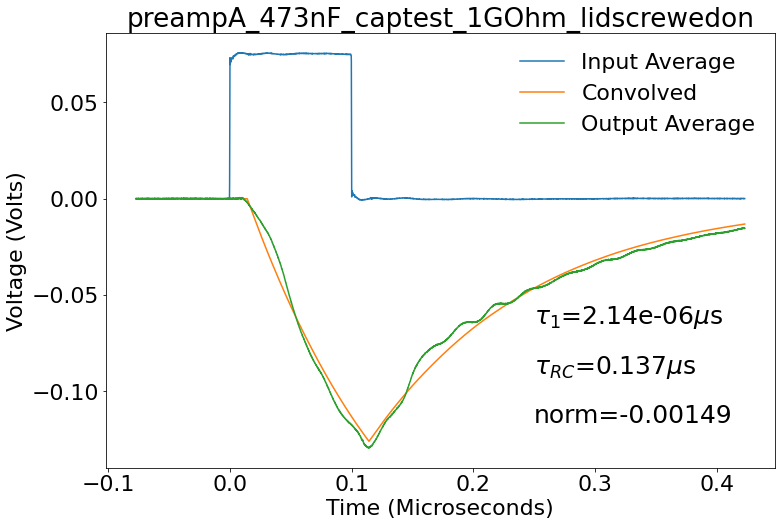

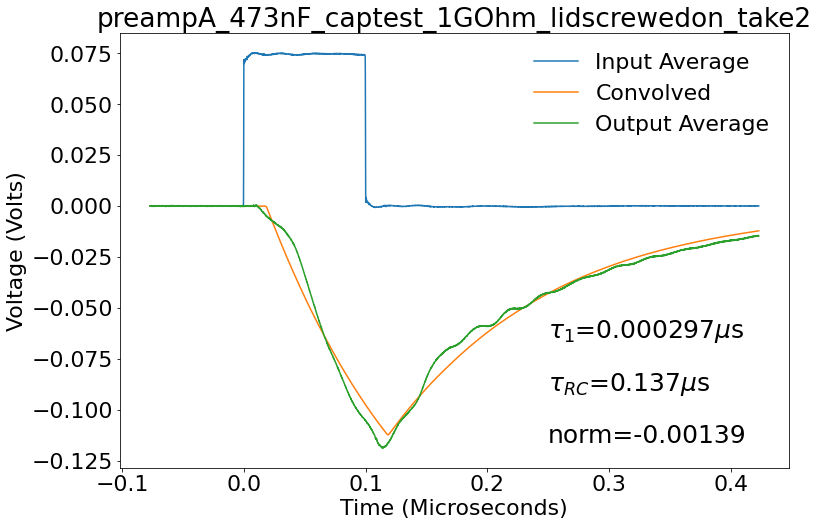

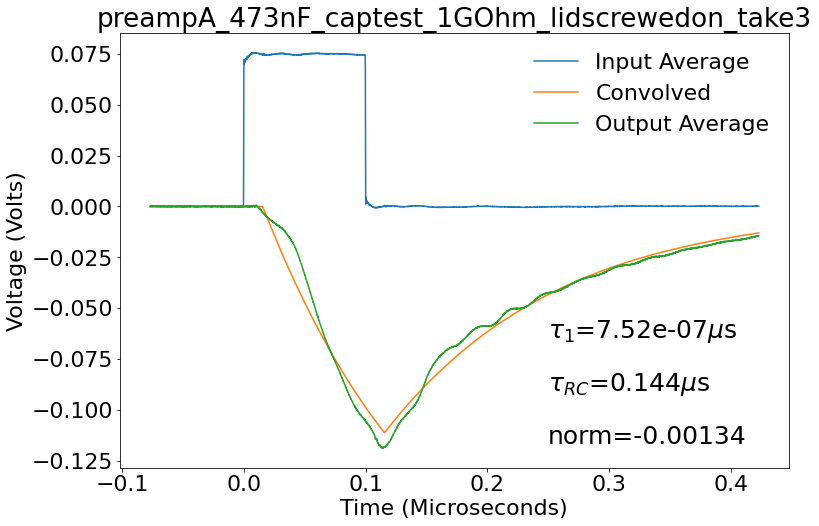

In [67]:
def func(xdata,offset,tau,norm):
    return signal.convolve(xdata, response(timeList,offset,tau,norm), mode='full')[0:len(xdata)] 

def func2(xdata,offset,tau,tauRise,norm):
    return signal.convolve(xdata, response2(timeList,offset,tau,tauRise,norm), mode='full')[0:len(xdata)] 

import scipy.signal as signal
from scipy.optimize import curve_fit

for idx,output in enumerate(outputAvg):
    popt, pcov = curve_fit(func2, inputAvg[idx], outputAvg[idx],p0=[offset,tau,tauRise,-1*norm])
    print(popt)
    fig, ax = plt.subplots()
    ax.plot(timeList,inputAvg[idx],label="Input Average")
    ax.plot(timeList,func2(inputAvg[idx],popt[0],popt[1],popt[2],popt[3]),label="Convolved")
    ax.plot(timeList,outputAvg[idx],label="Output Average")
    ax.set_title(fileBaseList[idx])
    ax.set_xlabel("Time (Microseconds)")
    ax.set_ylabel("Voltage (Volts)")
    ax.legend()

    minVal=np.min(outputAvg)

    textLabel=r"$\tau_1$="+f"{popt[2]:1.3g}"+"$\mu$s"
    plt.text(0.25, minVal*0.5, textLabel, fontsize=25)
    textLabel=r"$\tau_{RC}$="+f"{popt[1]:1.3g}"+"$\mu$s"
    plt.text(0.25, minVal*0.7, textLabel, fontsize=25)#ax.set_xlim(-0.01,0.111)
    textLabel=r"norm="+f"{popt[3]:1.3g}"
    plt.text(0.25, minVal*0.9, textLabel, fontsize=25)#ax.set_xlim(-0.01,0.111)



/var/folders/tt/td83hb5118g0l77wvd_87jfr0000gn/T/ipykernel_78440/2203500186.py:4: RuntimeWarning: overflow encountered in exp
  return norm*(1/(1+np.exp(-(x-offset)/tauRise)))*np.exp(-x/tau)  #the lambda keyword is allowing us to define a quick function


Text(0, 0.5, 'Response (units?)')

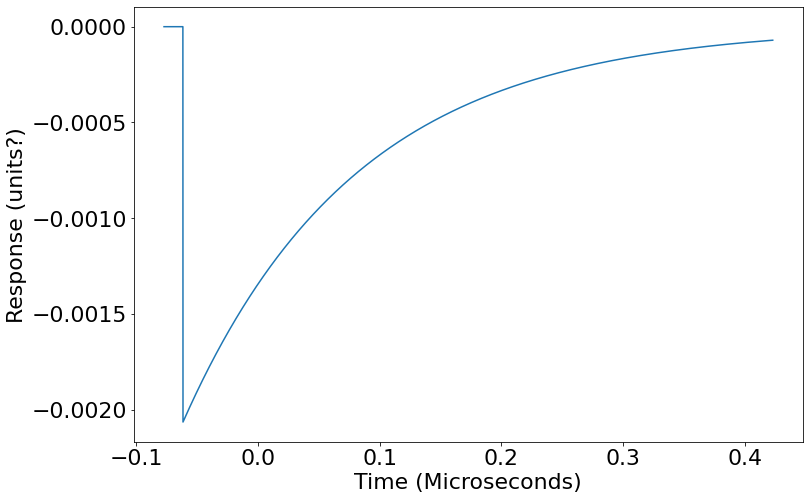

In [68]:

    
fig, ax = plt.subplots(facecolor='white')
ax.plot(timeList[0:10000],response2(timeList[0:10000],popt[0],popt[1],popt[2],popt[3]),label="Response Function")
ax.set_xlabel("Time (Microseconds)")
ax.set_ylabel("Response (units?)")